# Generate a color histogram lookup for weighting classifier

In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import numpy as np
from tqdm import tqdm_notebook as tqdm
from dataset import ColorizeHD5Dataset
from scipy.ndimage.filters import gaussian_filter

from dataset import (torch_softmax2image, hd52numpy, hd52numpy, lab2pil, img2hdf5, ab2bin, 
    bin2ab, ColorizeHD5Dataset,CategoricalColorizeDataSet, idx_to_lab)
from torchvision import transforms
import torch.utils.data as data

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lab_bins = np.load('lab_idx.npy')

- 1, populate a 3d histogram from images
- 2, padd the edges with nearest bins
- 3, smooth them out with a gaussian
- 4, show resulting distribution

In [3]:
a_min, a_max = lab_bins[:,0].min(), lab_bins[:,0].max()
b_min, b_max = lab_bins[:,1].min(), lab_bins[:,1].max()
a_min, a_max, b_min, b_max

(4, 22, 2, 22)

In [4]:
histo_grid = np.zeros((24,24))

In [5]:
ds_train = CategoricalColorizeDataSet('/home/ec2-user/data/train',  transform=transforms.Compose([
                            #transforms.RandomRotation(15, expand=False),
                            transforms.Resize(299),
                            transforms.CenterCrop(256),
                            #transforms.RandomHorizontalFlip(),
                           ]))
train_loader = data.DataLoader(ds_train,batch_size=16, shuffle=True, num_workers=8)

In [6]:
inputs, labels = next(iter(train_loader))
lbls = np.uint8(labels.numpy())
idxs, counts = np.unique(lbls, return_counts=True)
idxs.shape[0], counts.shape

(157, (157,))

In [7]:
total_counts = np.zeros((262,))
total_counts.shape

(262,)

In [8]:
total_counts = np.zeros((262,))
for inputs, labels in tqdm(train_loader):
    lbls = np.uint8(labels.numpy())
    idxs, counts = np.unique(lbls, return_counts=True)
    for i in range(idxs.shape[0]):
        total_counts[idxs[i]] +=  counts[i]

In [10]:
np.save('total_counts.npy', total_counts )

In [11]:
total_counts/=total_counts.sum()
for i in range(262):
    a,b = lab_bins[i,0], lab_bins[i,1]
    histo_grid[a,b] = total_counts[i]

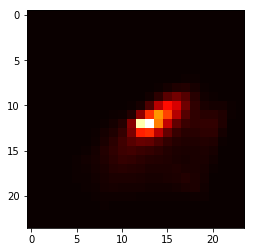

In [17]:
blurred = gaussian_filter(histo_grid, sigma=0.5)
plt.imshow(blurred, cmap='hot', interpolation='nearest')
plt.show()

In [18]:
weighting = 1.0/( 0.5 * blurred + 0.5/262)

In [19]:
za = np.ones((24, 24))
za[lab_bins[:,0], lab_bins[:,1]] = 0
mask = za > 0
weighting[mask] = 0

In [53]:
weighting.max()

9975.687440262182

In [54]:
weighting.max()/weighting[weighting > 0].min()

392.77914998263583

In [55]:
final_weights = weighting/weighting.sum()

In [56]:
weighting_factor = np.zeros((262,))
for i in range(lab_bins.shape[0]):
    a = lab_bins[i,0]
    b = lab_bins[i,1]
    weighting_factor[i] = final_weights[a,b]

In [57]:
np.save('color_weights_extreme.npy', weighting_factor)